# CSV -> NPZ (PID)

In [1]:


import pandas as pd
import numpy as np
from glob import glob
import os




csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
csv_dir3 = "/home/minchanggi/code/TCLab/data/added_data/PID/csv"

# CSV 파일 목록 수집
csv_files_1 = sorted(glob(os.path.join(csv_dir, 'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2, 'PID_episode_*_data.csv')))
csv_files_3 = sorted(glob(os.path.join(csv_dir3, 'PID_episode_*_data.csv')))
csv_files = csv_files_1 + csv_files_2 + csv_files_3

csv_dir_online = "/home/minchanggi/code/TCLab/data/online_train_data"
csv_dir_online2= "/home/minchanggi/code/TCLab/data/online_train_data/new"
csv_dir_online3="/home/minchanggi/code/TCLab/data/online_train_data/new2"
csv_dir_online4="/home/minchanggi/code/TCLab/data/online_train_data/new3"
csv_dir_online5="/home/minchanggi/code/TCLab/data/online_train_data/new4"
csv_dir_online6="/home/minchanggi/code/TCLab/data/online_train_data/new5"
csv_files_online = sorted(glob(os.path.join(csv_dir_online, "*.csv")))
csv_files_online2 = sorted(glob(os.path.join(csv_dir_online2, "*.csv")))
csv_files_online3 = sorted(glob(os.path.join(csv_dir_online3, "*.csv")))
csv_files_online4 = sorted(glob(os.path.join(csv_dir_online4, "*.csv")))
csv_files_online5 = sorted(glob(os.path.join(csv_dir_online5, "*.csv")))
csv_files_online6 = sorted(glob(os.path.join(csv_dir_online6, "*.csv")))
csv_online_files=csv_files_online+ csv_files_online2 +csv_files_online3+csv_files_online4+csv_files_online5+csv_files_online6

total_merge_csv=csv_files+csv_online_files

print(len(csv_files_1), len(csv_files_2), len(csv_files_3))
print("총 파일 수:", len(csv_files))

print("online 파일 수", len(csv_online_files))

print(len(total_merge_csv))

50 46 34
총 파일 수: 130
online 파일 수 77
207


## 실험 1
- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상: 목표온도 - 측정온도

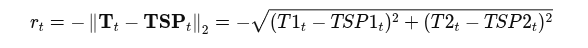

In [ ]:

npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline1_T-Tsp_bbb.npz"

all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    obs = df[['T1','T2','TSP1','TSP2']].values[:-1]
    next_obs = df[['T1','T2','TSP1','TSP2']].values[1:]
    actions=df[['Q1','Q2']].values[:-1]
    rewards = -np.linalg.norm(
        df[['T1','T2']].values[:-1] - df[['TSP1','TSP2']].values[:-1],
        axis=1,
        keepdims=True
    )
    terminals=np.zeros((len(obs),1),dtype=np.float32)
    terminals[-1]=0.0
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")

## 실험 2
- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상: 목표온도(t+1) - 측정온도(t+1)

t시점의 Q를 제어할 경우 t시점의 T1,T2에 영향을 끼치는 것이 아닌 t+1시점의 T1,T2가 영향을 끼치게 됨.
그렇기에 다음 시점의 목표온도와 측정온도의 차이를 보상함수로 지정함.

In [ ]:

output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ"

npz_output_path = os.path.join(output_path, "offline2_T-Tsp_next.npz")
csv_output_path = os.path.join(output_path, "offline2_T-Tsp_next.csv")

# 데이터 저장용 리스트
all_obs = []
all_next_obs = []
all_actions = []
all_rewards = []
all_terminals = []
csv_rows = []

# 파일별 데이터 처리
for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    #print(f"처리 중: {file_path}")

    obs = df[['T1','TSP1','T2','TSP2']].values[:-1]
    next_obs = df[['T1','TSP1','T2','TSP2']].values[1:]
    actions = df[['Q1','Q2']].values[:-1]
    rewards = -np.linalg.norm(
        df[['T1','T2']].values[1:] - df[['TSP1','TSP2']].values[:-1],
        axis=1
    )
    terminals = np.zeros(len(obs), dtype=np.float32)
    terminals[-1] = 1.0

    # npz용
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

    # 한 줄씩 저장
    for i in range(len(obs)):
        csv_rows.append([
            *obs[i],          # T1, TSP1, T2, TSP2
            *actions[i],      # Q1, Q2
            rewards[i],       # reward
            *next_obs[i],     # next_T1, next_TSP1, next_T2, next_TSP2
            terminals[i]      # terminal
        ])

# npz 저장
dataset = {
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.concatenate(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals': np.concatenate(all_terminals),
}
print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['next_observations'].shape)
print(dataset['terminals'].shape)
np.savez(npz_output_path, **dataset)
print(f"✅ NPZ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")

# 하나의 CSV로 저장
columns = [
    "T1", "TSP1", "T2", "TSP2",
    "Q1", "Q2",
    "reward",
    "next_T1", "next_TSP1", "next_T2", "next_TSP2",
    "terminal"
]
csv_df = pd.DataFrame(csv_rows, columns=columns)
csv_df.to_csv(csv_output_path, index=False)
print(f"✅ CSV 저장 완료: {csv_df.shape[0]} rows")
print(f"→ {csv_output_path}")


## 실험 3

- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2


앞선 방식들은 올바른 액션을 취해도 현재 상태가 좋지 않으면 보상 또한 좋지 않았다.

즉, 보상이 액션이 아닌 상태에 의존적이었다.

ex) 

Tsp가 60일때

    T가 20일 때 Q를 100으로 하여도 -40의 보상

    T가 50일 때 Q를 100으로 하면 -10의 보상

즉, 둘 다 올바른 행동이었지만 상태에 따라 보상이 달라진다.

- 보상:  PBRS(Potential-Based Reward Shaping) 적용 

-> Φ(t) = -‖T_t - TSP_t‖

-> reward_t = Φ(t+1) - Φ(t) 




현재의 행동으로 인해 다음 상태의 개선정도가 보상으로서 작용된다.

| 상황             | PBRS 보상     | 유도되는 행동  |
|------------------|---------------|----------------|
| 목표에 가까워짐  | 양의 보상 ↑   | 접근           |
| 그대로 유지      | 거의 0        | 정지 유지       |
| 목표에서 멀어짐  | 음의 보상 ↓   | 복귀 시도       |


In [ ]:
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline3_PBRS.npz"

all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    #print(file_path)

    obs = df[['T1','TSP1','T2','TSP2']].values[:-1]
    next_obs = df[['T1','TSP1','T2','TSP2']].values[1:]
    actions = df[['Q1','Q2']].values[:-1]
    
    # PBRS 보상
    gamma = 0.99
    T = df[['T1','T2']].values
    TSP = df[['TSP1','TSP2']].values
    phi = -np.linalg.norm(T - TSP, axis=1, keepdims=False)
    rewards = gamma * phi[1:] - phi[:-1]

    terminals=np.zeros((len(obs)),dtype=np.float32)
    terminals[-1]=0.0
    #print(rewards)
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)


                     
dataset = {
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.concatenate(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals': np.concatenate(all_terminals),
}

print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['next_observations'].shape)
print(dataset['terminals'].shape)
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")


## 실험 4

- 상태: T1, T2, TSP1, TSP2 
- 액션: Q1, Q2
- 보상:  PBRS + 기존보상함수 적용 

-> Φ(t) = -‖T_t - TSP_t‖

-> rt = 목표온도(t+1) - 측정온도(t+1) //개선정도와 더불어 측정온도와 목표온도 사이의 차이를 보상으로 함.

-> reward_t = rt + γ * Φ(t+1) - Φ(t) 

개선정도와 기존 보상의 정규화를 위해 min, max 정규화를 시도함.


In [ ]:
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline4_PBRS_reward.npz"



all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    #print(file_path)
    obs = df[['T1','TSP1','T2','TSP2']].values[:-1]
    next_obs = df[['T1','TSP1','T2','TSP2']].values[1:]
    actions = df[['Q1','Q2']].values[:-1]
    
    # PBRS 보상
    gamma = 0.99
    T = df[['T1','T2']].values
    TSP = df[['TSP1','TSP2']].values
    phi = -np.linalg.norm(T - TSP, axis=1, keepdims=False)
    pbrs_term = gamma * phi[1:] - phi[:-1]
    


    # ② 오차 기반 보상: 다음 시점에서의 목표 온도와의 거리
    error_term = -np.linalg.norm(
        df[['T1','T2']].values[1:] - df[['TSP1','TSP2']].values[:-1],
        axis=1,
        keepdims=False
    )
    # Min-Max 정규화
    pbrs_norm = (pbrs_term - pbrs_term.min()) / (pbrs_term.max() - pbrs_term.min() + 1e-8)
    error_norm = (error_term - error_term.min()) / (error_term.max() - error_term.min() + 1e-8)

    # 결합 보상
    rewards = pbrs_norm + error_norm

    terminals=np.zeros((len(obs)),dtype=np.float32)
    terminals[-1]=0.0
    #print(rewards)
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)


dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.concatenate(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.concatenate(all_terminals),
}
print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['next_observations'].shape)
print(dataset['terminals'].shape)
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")

## 실험5

앞선 4개의 보상함수 실험을 거쳐 가장 성능이 좋았던 2, 4번 실험의 보상함수를 바탕으로 주어지는 상태에 대한 실험을 진행하고자 함.

기존 상태 T1(t), T2(t), TSP1(t), TSP2(t) 에 더해 온도변화량(T(t-1) - T(t))를 추가한다.

- 상태: T1(t), T2(t), TSP1(t), TSP2(t),  T1(t-1) - T1(t), T2(t-1) - T2(t) 
- 액션: Q1, Q2
- 보상:  목표온도(t+1) - 측정온도(t+1)

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import os


output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ"

npz_output_path = os.path.join(output_path, "offline5_deltaT.npz")
csv_output_path = os.path.join(output_path, "offline5_deltaT.csv")

# 데이터 저장용 리스트
all_obs = []
all_next_obs = []
all_actions = []
all_rewards = []
all_terminals = []
csv_rows = []

# 파일별 데이터 처리
for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    print(f"처리 중: {file_path}")
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values

    dT1 = np.concatenate([[0.0], T1[1:] - T1[:-1]])
    dT2 = np.concatenate([[0.0], T2[1:] - T2[:-1]])

    obs = np.stack([T1[:-1], TSP1[:-1], dT1[:-1], T2[:-1], TSP2[:-1], dT2[:-1]], axis=1)
    next_obs = np.stack([T1[1:], TSP1[1:], dT1[1:], T2[1:], TSP2[1:], dT2[1:]], axis=1)
    actions = np.stack([Q1[:-1], Q2[:-1]], axis=1)

    rewards = -np.linalg.norm(
        np.stack([T1[1:] - TSP1[:-1], T2[1:] - TSP2[:-1]], axis=1),
        axis=1
    )

    terminals = np.zeros(len(obs), dtype=np.float32)
    terminals[-1] = 1.0

    # npz용
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

    # csv용
    for i in range(len(obs)):
        csv_rows.append([
            *obs[i],              # T1, TSP1, dT1, T2, TSP2, dT2
            *actions[i],          # Q1, Q2
            rewards[i],           # reward
            *next_obs[i],         # next_T1, next_TSP1, next_dT1, next_T2, next_TSP2, next_dT2
            terminals[i]          # terminal
        ])

# npz 저장
dataset = {
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.concatenate(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals': np.concatenate(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ NPZ 저장 완료: {dataset['observations'].shape[0]} transitions, {dataset['observations'].shape[1]} features")
print(f"→ {npz_output_path}")

# csv 저장
columns = [
    "T1", "TSP1", "dT1", "T2", "TSP2", "dT2",
    "Q1", "Q2",
    "reward",
    "next_T1", "next_TSP1", "next_dT1", "next_T2", "next_TSP2", "next_dT2",
    "terminal"
]
df_csv = pd.DataFrame(csv_rows, columns=columns)
df_csv.to_csv(csv_output_path, index=False)
print(f"✅ CSV 저장 완료: {df_csv.shape[0]} rows")
print(f"→ {csv_output_path}")


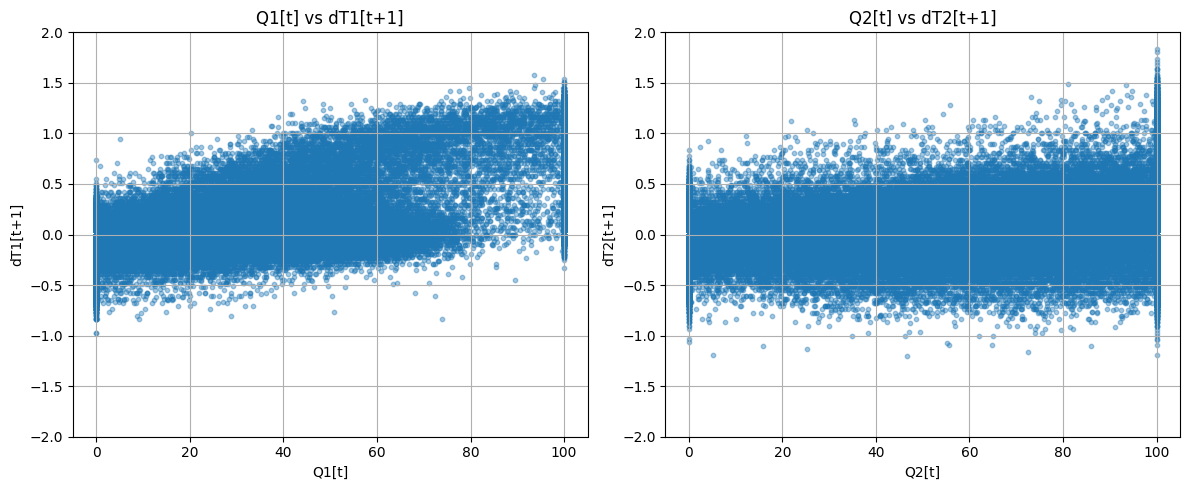

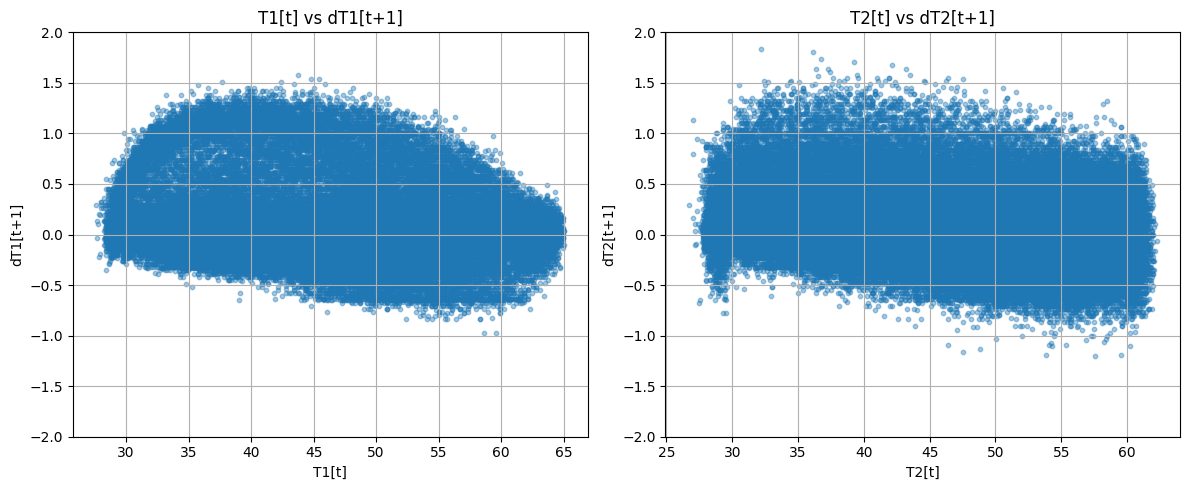

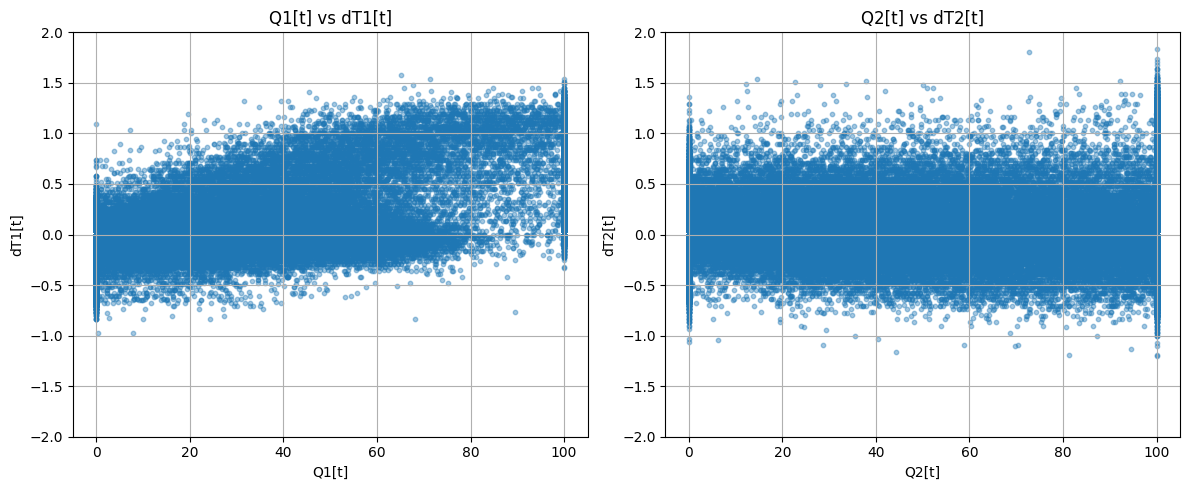

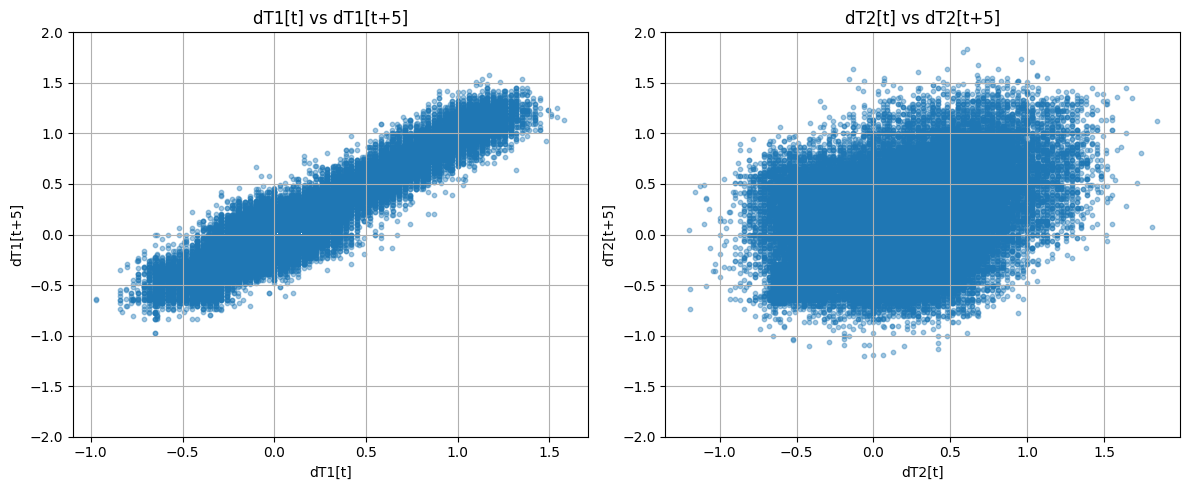

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로드
csv_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline8_delta5T.csv"
#csv_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline5_deltaT.csv"
df = pd.read_csv(csv_path)

# Q[t], T[t] → dT[t+1] 관계 정렬
q1 = df["Q1"].values[:-1]
q2 = df["Q2"].values[:-1]
t1 = df["T1"].values[:-1]
t2 = df["T2"].values[:-1]
dt1 = df["dT1"].values[1:]
dt2 = df["dT2"].values[1:]
dt1_cur = df["dT1"].values[:-1]
dt2_cur = df["dT2"].values[:-1]

# 🔹 Q vs dT
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(q1, dt1, alpha=0.4, s=10)
plt.title("Q1[t] vs dT1[t+1]")
plt.xlabel("Q1[t]")
plt.ylabel("dT1[t+1]")
plt.grid(True)
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.scatter(q2, dt2, alpha=0.4, s=10)
plt.title("Q2[t] vs dT2[t+1]")
plt.xlabel("Q2[t]")
plt.ylabel("dT2[t+1]")
plt.grid(True)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

# 🔹 T vs dT
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(t1, dt1, alpha=0.4, s=10)
plt.title("T1[t] vs dT1[t+1]")
plt.xlabel("T1[t]")
plt.ylabel("dT1[t+1]")
plt.grid(True)
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.scatter(t2, dt2, alpha=0.4, s=10)
plt.title("T2[t] vs dT2[t+1]")
plt.xlabel("T2[t]")
plt.ylabel("dT2[t+1]")
plt.grid(True)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(q1, dt1_cur, alpha=0.4, s=10)
plt.title("Q1[t] vs dT1[t]")
plt.xlabel("Q1[t]")
plt.ylabel("dT1[t]")
plt.grid(True)
plt.ylim(-2, 2)

plt.subplot(1, 2, 2)
plt.scatter(q2, dt2_cur, alpha=0.4, s=10)
plt.title("Q2[t] vs dT2[t]")
plt.xlabel("Q2[t]")
plt.ylabel("dT2[t]")
plt.grid(True)
plt.ylim(-2, 2)

plt.tight_layout()
plt.show()

dt1 = df["dT1"].values
dt2 = df["dT2"].values

prev_dt1 = dt1[:-1]
next_dt1 = dt1[1:]

prev_dt2 = dt2[:-1]
next_dt2 = dt2[1:]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(prev_dt1, next_dt1, alpha=0.4, s=10)
plt.title("dT1[t] vs dT1[t+5]")
plt.xlabel("dT1[t]")
plt.ylabel("dT1[t+5]")
plt.grid(True)
plt.ylim(-2, 2)

plt.subplot(1, 2, 2)
plt.scatter(prev_dt2, next_dt2, alpha=0.4, s=10)
plt.title("dT2[t] vs dT2[t+5]")
plt.xlabel("dT2[t]")
plt.ylabel("dT2[t+5]")
plt.grid(True)
plt.ylim(-2, 2)

plt.tight_layout()
plt.show()

## 실험6

앞선 4개의 보상함수 실험을 거쳐 가장 성능이 좋았던 2, 4번 실험의 보상함수를 바탕으로 주어지는 상태에 대한 실험을 진행하고자 함.

기존 상태 T1(t), T2(t), TSP1(t), TSP2(t) 에 더해 직전(t-1) Q를추가한다.

- 상태: T1(t), T2(t), TSP1(t), TSP2(t), Q1(t-1), Q2(t-1)
- 액션: Q1, Q2
- 보상:  목표온도(t+1) - 측정온도(t+1)

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import os

# 데이터 경로
csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline6_extra_state_prevQ.npz"



all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values
    
    dT1 = T1[:-1] - T1[1:]
    dT2 = T2[:-1] - T2[1:]
    
    
    obs = np.stack([T1[1:-1], T2[1:-1], TSP1[1:-1], TSP2[1:-1], Q1[:-2], Q2[:-2]], axis=1)
    
    next_obs = np.stack([T1[2:], T2[2:], TSP1[2:], TSP2[2:], Q1[1:-1], Q2[1:-1]], axis=1)
    
    actions = np.stack([Q1[1:-1], Q2[1:-1]], axis=1)

    
    rewards = -np.linalg.norm(
        np.stack([T1[2:] - TSP1[2:], T2[2:] - TSP2[2:]], axis=1),
        axis=1,
        keepdims=True
    )
    
    terminals = np.zeros((len(obs), 1), dtype=np.float32)
    terminals[-1] = 1.0
    
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)
    
dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.vstack(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.vstack(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")



50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
/home/minchanggi/code/TCLab/data/

## 실험7

앞선 4개의 보상함수 실험을 거쳐 가장 성능이 좋았던 2, 4번 실험의 보상함수를 바탕으로 주어지는 상태에 대한 실험을 진행하고자 함.

기존 상태 T1(t), T2(t), TSP1(t), TSP2(t) 에 더해 직전(t-1) Q와 온도변화량(T(t-1) - T(t))를 추가한다.

- 상태: T1(t), T2(t), TSP1(t), TSP2(t), Q1(t-1), Q2(t-1), T1(t-1) - T1(t), T2(t-1) - T2(t) 
- 액션: Q1, Q2
- 보상:  목표온도(t+1) - 측정온도(t+1)

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import os

# 데이터 경로
csv_dir = "/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv"
csv_dir2 = "/home/minchanggi/code/TCLab/data/PID600-1200/csv"
npz_output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline7_extra_state.npz"



all_obs=[]
all_next_obs=[]
all_actions=[]
all_rewards=[]
all_terminals=[]

csv_files_1 = sorted(glob(os.path.join(csv_dir,'PID_episode_*_data.csv')))
csv_files_2 = sorted(glob(os.path.join(csv_dir2,"PID_episode_*_data.csv")))
print(len(csv_files_1),len(csv_files_2))

csv_files = csv_files_1 + csv_files_2

for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df)<1000:
        continue
    print(file_path)
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values
    
    dT1 = T1[1:] - T1[:-1] # T_t - T_t-1
    dT2 = T2[1:] - T2[:-1]
    
    
    
    obs = np.stack([T1[1:-1], T2[1:-1], TSP1[1:-1], TSP2[1:-1], Q1[:-2], Q2[:-2], dT1[:-1], dT2[:-1]], axis=1)
    
    next_obs = np.stack([T1[2:], T2[2:], TSP1[2:], TSP2[2:], Q1[1:-1], Q2[1:-1], dT1[1:], dT2[1:]], axis=1)
    
    actions = np.stack([Q1[1:-1], Q2[1:-1]], axis=1)

    
    rewards = -np.linalg.norm(
        np.stack([T1[2:] - TSP1[2:], T2[2:] - TSP2[2:]], axis=1),
        axis=1,
        keepdims=False
    )
    
    terminals = np.zeros((len(obs)), dtype=np.float32)
    terminals[-1] = 1.0
    
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)
    
dataset={
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.concatenate(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals':np.concatenate(all_terminals),
}
np.savez(npz_output_path, **dataset)
print(f"✅ 저장 완료: {dataset['observations'].shape[0]} transitions")
print(f"→ {npz_output_path}")



50 46
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_10_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_11_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_12_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_13_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_14_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_15_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_16_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_17_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_18_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_19_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_1_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_20_data.csv
/home/minchanggi/code/TCLab/data/PID2MPC/PID3/csv/PID_episode_21_data.csv
/home/minchanggi/code/TCLab/data/

# lab8 

데이터 시각화 결과 dT를 1step만으로 측정하는 것보다 5step의 dT를 측정하는 것이 경향성이 더 잘 나타남.


기존 상태 T1(t), T2(t), TSP1(t), TSP2(t) 에 더해 온도변화량(T(t-1) - T(t))를 추가한다.

- 상태: T1(t), TSP1(t), T1(t-4) - T1(t), T2(t), TSP2(t),  T2(t-4) - T2(t) 
- 액션: Q1, Q2
- 보상:  목표온도(t+1) - 측정온도(t+1)

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os


output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ"

npz_output_path = os.path.join(output_path, "offline8_delta5T_2.npz")
csv_output_path = os.path.join(output_path, "offline8_delta5T_2.csv")

# 데이터 저장용 리스트
all_obs = []
all_next_obs = []
all_actions = []
all_rewards = []
all_terminals = []
csv_rows = []

# 파일별 데이터 처리
for file_path in csv_files:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    #print(f"처리 중: {file_path}")
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values

    dT1 = np.zeros_like(T1)
    dT2 = np.zeros_like(T2)
    
    for t in range(len(T1)):
        if t == 0:
            dT1[t] = 0  # 혹은 np.nan
            dT2[t] = 0
        elif t < 4:
            dT1[t] = T1[t] - T1[t-1]
            dT2[t] = T2[t] - T2[t-1]
        else:
            dT1[t] = T1[t] - T1[t-4]
            dT2[t] = T2[t] - T2[t-4]

    obs = np.stack([T1[:-1], TSP1[:-1], dT1[:-1], T2[:-1], TSP2[:-1], dT2[:-1]], axis=1)
    next_obs = np.stack([T1[1:], TSP1[1:], dT1[1:], T2[1:], TSP2[1:], dT2[1:]], axis=1)
    actions = np.stack([Q1[:-1], Q2[:-1]], axis=1)

    rewards = -np.linalg.norm(
        np.stack([T1[:-1] - TSP1[1:], T2[:-1] - TSP2[1:]], axis=1),
        axis=1
    )

    terminals = np.zeros(len(obs), dtype=np.float32)
    terminals[-1] = 1.0

    # npz용
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

    # csv용
    for i in range(len(obs)):
        csv_rows.append([
            *obs[i],              # T1, TSP1, dT1, T2, TSP2, dT2
            *actions[i],          # Q1, Q2
            rewards[i],           # reward
            *next_obs[i],         # next_T1, next_TSP1, next_dT1, next_T2, next_TSP2, next_dT2
            terminals[i]          # terminal
        ])

# npz 저장
dataset = {
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.concatenate(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals': np.concatenate(all_terminals),
}
print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['next_observations'].shape)
print(dataset['terminals'].shape)
np.savez(npz_output_path, **dataset)
print(f"✅ NPZ 저장 완료: {dataset['observations'].shape[0]} transitions, {dataset['observations'].shape[1]} features")
print(f"→ {npz_output_path}")

# csv 저장
columns = [
    "T1", "TSP1", "dT1", "T2", "TSP2", "dT2",
    "Q1", "Q2",
    "reward",
    "next_T1", "next_TSP1", "next_dT1", "next_T2", "next_TSP2", "next_dT2",
    "terminal"
]
df_csv = pd.DataFrame(csv_rows, columns=columns)
df_csv.to_csv(csv_output_path, index=False)
print(f"✅ CSV 저장 완료: {df_csv.shape[0]} rows")
print(f"→ {csv_output_path}")


(120998, 6)
(120998, 2)
(120998,)
(120998, 6)
(120998,)
✅ NPZ 저장 완료: 120998 transitions, 6 features
→ /home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline8_delta5T.npz
✅ CSV 저장 완료: 120998 rows
→ /home/minchanggi/code/TCLab/data/PID2MPC/NPZ/offline8_delta5T.csv


# 온라인 데이터 만들기

In [9]:


output_path = "/home/minchanggi/code/TCLab/data/PID2MPC/NPZ"

npz_output_path = os.path.join(output_path, "online8_delta5T_2_ToltalMerge.npz")
csv_output_path = os.path.join(output_path, "online8_delta5T_2_TotalMerge.csv")

# 데이터 저장용 리스트
all_obs = []
all_next_obs = []
all_actions = []
all_rewards = []
all_terminals = []
csv_rows = []

# 파일별 데이터 처리
for file_path in total_merge_csv:
    df = pd.read_csv(file_path)
    if len(df) < 1000:
        continue
    #print(f"처리 중: {file_path}")
    
    T1 = df['T1'].values
    T2 = df['T2'].values
    TSP1 = df['TSP1'].values
    TSP2 = df['TSP2'].values
    Q1 = df['Q1'].values
    Q2 = df['Q2'].values

    dT1 = np.zeros_like(T1)
    dT2 = np.zeros_like(T2)
    
    for t in range(len(T1)):
        if t == 0:
            dT1[t] = 0  # 혹은 np.nan
            dT2[t] = 0
        elif t < 4:
            dT1[t] = T1[t] - T1[t-1]
            dT2[t] = T2[t] - T2[t-1]
        else:
            dT1[t] = T1[t] - T1[t-4]
            dT2[t] = T2[t] - T2[t-4]

    obs = np.stack([T1[:-1], TSP1[:-1], dT1[:-1], T2[:-1], TSP2[:-1], dT2[:-1]], axis=1)
    next_obs = np.stack([T1[1:], TSP1[1:], dT1[1:], T2[1:], TSP2[1:], dT2[1:]], axis=1)
    actions = np.stack([Q1[:-1], Q2[:-1]], axis=1)

    rewards = -np.linalg.norm(
        np.stack([T1[:-1] - TSP1[1:], T2[:-1] - TSP2[1:]], axis=1),
        axis=1
    )

    terminals = np.zeros(len(obs), dtype=np.float32)
    terminals[-1] = 1.0

    # npz용
    all_obs.append(obs)
    all_next_obs.append(next_obs)
    all_actions.append(actions)
    all_rewards.append(rewards)
    all_terminals.append(terminals)

    # csv용
    for i in range(len(obs)):
        csv_rows.append([
            *obs[i],              # T1, TSP1, dT1, T2, TSP2, dT2
            *actions[i],          # Q1, Q2
            rewards[i],           # reward
            *next_obs[i],         # next_T1, next_TSP1, next_dT1, next_T2, next_TSP2, next_dT2
            terminals[i]          # terminal
        ])

# npz 저장
dataset = {
    'observations': np.vstack(all_obs),
    'actions': np.vstack(all_actions),
    'rewards': np.concatenate(all_rewards),
    'next_observations': np.vstack(all_next_obs),
    'terminals': np.concatenate(all_terminals),
}
print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['next_observations'].shape)
print(dataset['terminals'].shape)
np.savez(npz_output_path, **dataset)
print(f"✅ NPZ 저장 완료: {dataset['observations'].shape[0]} transitions, {dataset['observations'].shape[1]} features")
print(f"→ {npz_output_path}")

# csv 저장
columns = [
    "T1", "TSP1", "dT1", "T2", "TSP2", "dT2",
    "Q1", "Q2",
    "reward",
    "next_T1", "next_TSP1", "next_dT1", "next_T2", "next_TSP2", "next_dT2",
    "terminal"
]
df_csv = pd.DataFrame(csv_rows, columns=columns)
df_csv.to_csv(csv_output_path, index=False)
print(f"✅ CSV 저장 완료: {df_csv.shape[0]} rows")
print(f"→ {csv_output_path}")


(213321, 6)
(213321, 2)
(213321,)
(213321, 6)
(213321,)
✅ NPZ 저장 완료: 213321 transitions, 6 features
→ /home/minchanggi/code/TCLab/data/PID2MPC/NPZ/online8_delta5T_2_ToltalMerge.npz
✅ CSV 저장 완료: 213321 rows
→ /home/minchanggi/code/TCLab/data/PID2MPC/NPZ/online8_delta5T_2_TotalMerge.csv
